In [67]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

# Data preprocessing and EDA

In [146]:
pd.set_option('display.max_columns', None)

In [147]:
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')

#Get rid of outliers - fires of size larger than 5000 acres
df = df.loc[df['fire_size'] < 5000]
df.columns

Index(['fire_name', 'fire_size', 'fire_size_class', 'stat_cause_descr',
       'latitude', 'longitude', 'state', 'disc_clean_date', 'discovery_month',
       'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf',
       'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear',
       'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15',
       'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7',
       'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [148]:
#one hot encoding vegetation
df['Vegetation'] = df['Vegetation'].astype('category')
df['Cause'] = df['stat_cause_descr'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df = pd.get_dummies(df,prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)

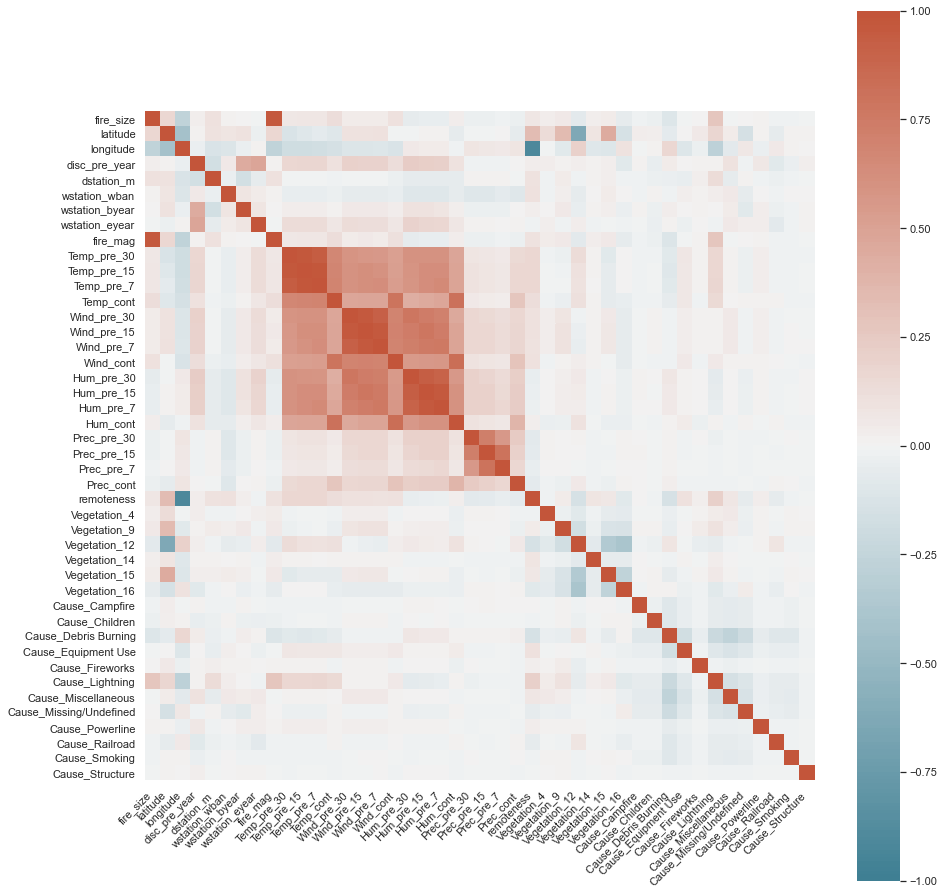

In [149]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(15,16)})

In [150]:
### Dealing with missing data
print(len(df))

# drop columns where weather file is missing
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))


51395
37915


In [151]:
# Weather data has a lot of 0 and values some of which may be missing values
# Mark '0' values in weather columns as Na (to see how many there are)
subset0 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset0] = df[subset0].replace({0:np.nan, '0':np.nan})
print(len(df))

# Mark '-1' as missing
subset_neg1 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont',])
print(len(df))
# This leaves us with 38,689 observations to work with (originally we had 50,000)

37915
35683


In [152]:
# fill the 'pre' columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill NAs in the date of fire containment based on mean values from previous days
for col in ['Temp','Wind','Hum']:
    df[f'{col}_cont'] = df.apply(
        lambda row: (row[f'{col}_pre_7']+row[f'{col}_pre_15']+row[f'{col}_pre_30'])/3 if np.isnan(row[f'{col}_cont']) else row[f'{col}_cont'],
        axis=1)

## Experiment data preparation

### Experiment 1
Including all the available variables in the model

In [153]:
# selecting features and target variables
X1 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size']

#train test split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
df1 = [X1_train, X1_test, y_train, y_test]

### Experiment 2
Include only long, lat, vegetation, cause and pre- weather data, without cont-

In [154]:
# selecting features and target variables
X2 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size']

#train test split
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
df2 = [X2_train, X2_test, y_train, y_test]

### Experiment 3
Including only lat, long and weather pre- data

In [155]:
# selecting features and target variables
X3 = df[['latitude','longitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7']]
y = df['fire_size']

#train test split
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)
df3 = [X3_train, X3_test, y_train, y_test]

### Experiment 4
Like exp 1 but with normalization

In [156]:
df_4 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
names = df_4.columns

# normalizing data
df_4 = preprocessing.normalize(df_4)
scaled_df = pd.DataFrame(df_4, columns=names)

#train test split
X4_train, X4_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.2, random_state=42)
df4 = [X4_train, X4_test, y_train, y_test]

# Modelling
### Decision Tree - Experiment 1

In [139]:
dectr = DecisionTreeRegressor(random_state=0)
dectr.fit(df1[0], df1[2])

predictions = dectr.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 237.82117965671853
R Squared: -0.36114928353190257


### Gradient Boosting - Experiment 1

In [140]:
gr_boost = GradientBoostingRegressor()
gr_boost.fit(df1[0], df1[2])

predictions = gr_boost.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 248.17209005834303
R Squared: 0.1849128914702617


### Random Forest - Experiment 1

In [141]:
rf = RandomForestRegressor()
rf.fit(df1[0], df1[2])

predictions = rf.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 238.1494868854997
R Squared: 0.24924474788788586


## Modelling - Experiments

In [142]:
# less than 5000
for model in [DecisionTreeRegressor(), GradientBoostingRegressor(), RandomForestRegressor()]:
    for idx,df in enumerate([df1, df2, df3, df4]):
        model.fit(df[0], df[2])
        print(f'{model}; Experiment {idx+1}; Mean Absolute Error:', metrics.mean_absolute_error(df[3], model.predict(df[1])))
        print(f'{model}; Experiment {idx+1}; R Squared:', metrics.r2_score(df[3], model.predict(df[1])))
        print('')

DecisionTreeRegressor(); Experiment 1; Mean Absolute Error: 229.82427341319882
DecisionTreeRegressor(); Experiment 1; R Squared: -0.3053514280851082

DecisionTreeRegressor(); Experiment 2; Mean Absolute Error: 253.2557415552753
DecisionTreeRegressor(); Experiment 2; R Squared: -0.465436142634692

DecisionTreeRegressor(); Experiment 3; Mean Absolute Error: 258.3314262771473
DecisionTreeRegressor(); Experiment 3; R Squared: -0.5097004952331017

DecisionTreeRegressor(); Experiment 4; Mean Absolute Error: 260.29781902480033
DecisionTreeRegressor(); Experiment 4; R Squared: -0.5205174030670696

GradientBoostingRegressor(); Experiment 1; Mean Absolute Error: 248.1197075556288
GradientBoostingRegressor(); Experiment 1; R Squared: 0.18474955329957554

GradientBoostingRegressor(); Experiment 2; Mean Absolute Error: 251.921126818388
GradientBoostingRegressor(); Experiment 2; R Squared: 0.17029756102730786

GradientBoostingRegressor(); Experiment 3; Mean Absolute Error: 257.3121837751193
Gradient

The best performing basemodel is the Random Forest algorithm with R2 of 23%. This is the model we will use for further analysis and improvement.

### Fetaure Importance
What features are the most influential in the model?

In [143]:
feature_importances = pd.DataFrame(rf.feature_importances_,
    index = df1[0].columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
longitude,0.170035
latitude,0.107270
Hum_cont,0.080356
Wind_cont,0.058098
Temp_cont,0.054153
Cause_Lightning,0.047986
Hum_pre_7,0.045891
Wind_pre_7,0.043315
Temp_pre_7,0.043188
Hum_pre_30,0.041612


In [157]:
# selecting features and target variables
X = df[['Vegetation_9','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Lightning','longitude']]

#train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

Reevaluate model after deleting least important features

In [158]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor()

# fit the regressor with x and y data
rf_reg.fit(X2_train, y2_train)

predictions = rf_reg.predict(X2_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, predictions))
print('R Squared:', metrics.r2_score(y2_test, predictions))

Mean Absolute Error: 240.4015138429899
R Squared: 0.2424247532514412


### Hyper-parameter tuning
Performing Grid Search

Testing the model with different values for parameters like the number of estimators and maximum depth, and then selects the parametres that produce the best results.

The basemodel of Random Forest Regressor produced the best results, so that is the algorithm we will tune.

In [159]:
rf_reg = RandomForestRegressor()
search_grid={'n_estimators':[50,100,200],'max_depth':[2,5,8,10]}
search=GridSearchCV(estimator=rf_reg,param_grid=search_grid,scoring='neg_mean_absolute_error',n_jobs=1,cv=5, verbose=1)
search.fit(df1[0], df1[2])
print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
-225.4293528623764
{'max_depth': 10, 'n_estimators': 200}


### Random Forest
Running Random Forest with parameters found with GridSearch

In [161]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 200, max_depth=10)

# fit the regressor with x and y data
rf_reg.fit(df1[0], df1[2])

predictions = rf_reg.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 235.34111221959054
R Squared: 0.22391477346879352


### Partial Dependence Plot
See how each feature affects  the target variable

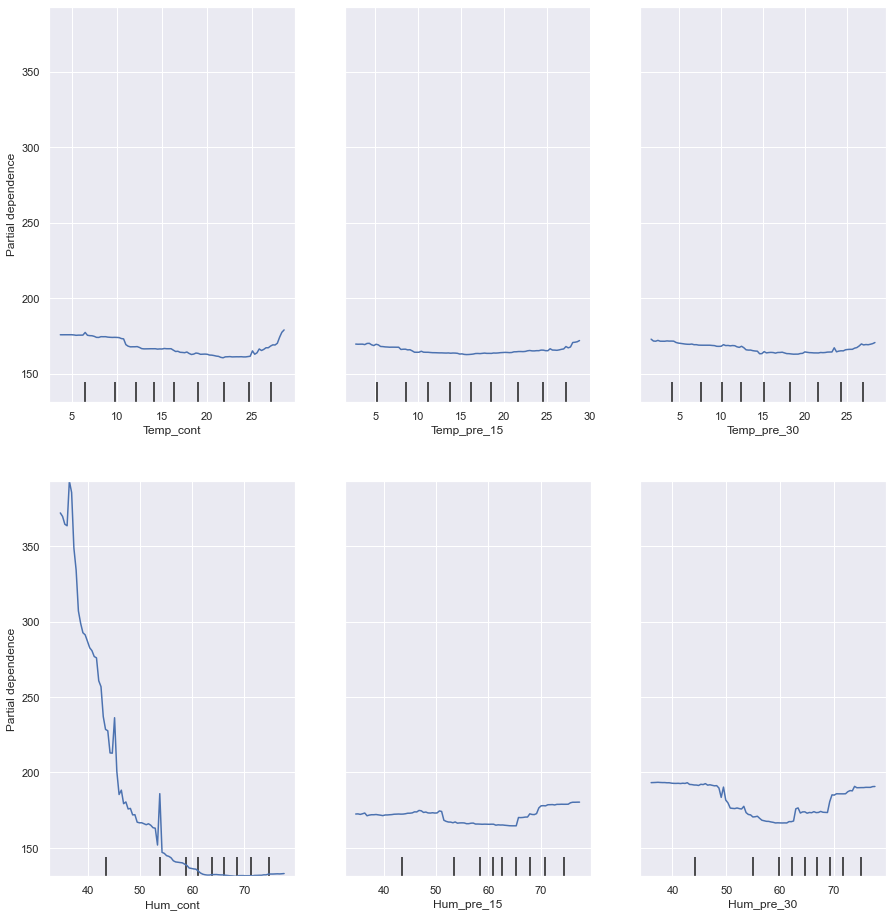

In [162]:
features = ['Temp_cont','Temp_pre_15', 'Temp_pre_30','Hum_cont','Hum_pre_15','Hum_pre_30']
plot_partial_dependence(rf_reg, df1[0], features)

### Neural network model

In [163]:
# selecting features and target variables
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [164]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

2021-12-03 09:15:08.122744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 09:15:08.223674: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [216]:
X_train.shape

(28546, 34)

In [224]:
model = Sequential([
    #normalizer,
    Dense(34, activation="relu", kernel_regularizer = regularizers.l2(0.01), kernel_initializer='normal',input_dim = X_train.shape[1]),
    Dense(34, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(64, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(32, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy','mae']
)

In [225]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_split=0.15,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=20,
        mode='min',
        restore_best_weights=True
    )]
)

Epoch 1/200
759/759 [==============================] - 2s 1ms/step - loss: 487682.4062 - accuracy: 0.2138 - mae: 257.0800 - val_loss: 488079.5312 - val_accuracy: 0.2167 - val_mae: 234.0198
Epoch 2/200
759/759 [==============================] - 1s 1ms/step - loss: 472290.5000 - accuracy: 0.2169 - mae: 259.4323 - val_loss: 476308.5312 - val_accuracy: 0.2167 - val_mae: 246.6796
Epoch 3/200
759/759 [==============================] - 1s 2ms/step - loss: 467457.4062 - accuracy: 0.2167 - mae: 255.9803 - val_loss: 466795.9375 - val_accuracy: 0.2167 - val_mae: 278.9338
Epoch 4/200
759/759 [==============================] - 1s 2ms/step - loss: 463128.0000 - accuracy: 0.2171 - mae: 256.0681 - val_loss: 466665.5312 - val_accuracy: 0.2167 - val_mae: 300.0284
Epoch 5/200
759/759 [==============================] - 1s 1ms/step - loss: 462329.3438 - accuracy: 0.2170 - mae: 252.7378 - val_loss: 457930.5938 - val_accuracy: 0.2167 - val_mae: 231.5145
Epoch 6/200
759/759 [==============================] - 

759/759 [==============================] - 1s 1ms/step - loss: 428151.1875 - accuracy: 0.2170 - mae: 233.9577 - val_loss: 444390.8125 - val_accuracy: 0.2167 - val_mae: 298.8236
Epoch 45/200
759/759 [==============================] - 1s 1ms/step - loss: 430278.0000 - accuracy: 0.2169 - mae: 237.8191 - val_loss: 429001.1875 - val_accuracy: 0.2167 - val_mae: 233.2891
Epoch 46/200
759/759 [==============================] - 1s 1ms/step - loss: 428860.0625 - accuracy: 0.2169 - mae: 235.2454 - val_loss: 420101.5625 - val_accuracy: 0.2167 - val_mae: 229.2744
Epoch 47/200
759/759 [==============================] - 1s 1ms/step - loss: 428265.9375 - accuracy: 0.2171 - mae: 237.2596 - val_loss: 462153.0938 - val_accuracy: 0.2167 - val_mae: 186.3608
Epoch 48/200
759/759 [==============================] - 1s 1ms/step - loss: 430014.6250 - accuracy: 0.2169 - mae: 234.8325 - val_loss: 418525.4062 - val_accuracy: 0.2167 - val_mae: 229.9681
Epoch 49/200
759/759 [==============================] - 1s 1ms/

In [226]:
test_loss, test_acc, test_mae = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Mean Absolute Error: {acc:0.3f}'.format(acc=test_mae))
print('accuracy: {acc:0.3f}'.format(acc=test_acc))
print('loss: {acc:0.3f}'.format(acc=test_loss))

# MAE with normalization and regularization: 239.722
# MAE with normalization: 216.653

# without normalization
# MAE with l1 regularization (r=0.1): 225.844 - learns faster
# MAE with l2 regularization (r=0.1):  219.094
# MAE with l2 regularization (r=0.01): 195.898

Mean Absolute Error: 195.898
accuracy: 0.220
loss: 495441.375


In [227]:
historydf = pd.DataFrame(history.history)

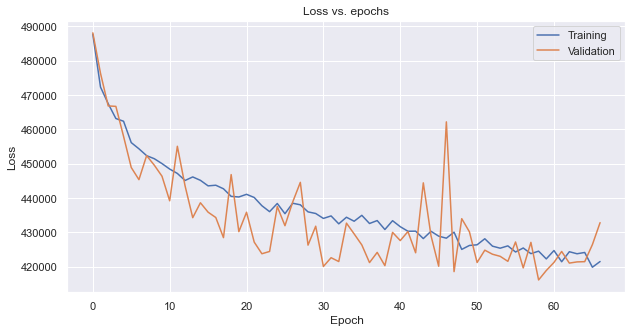

In [228]:
#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['loss'])
plt.plot(historydf['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

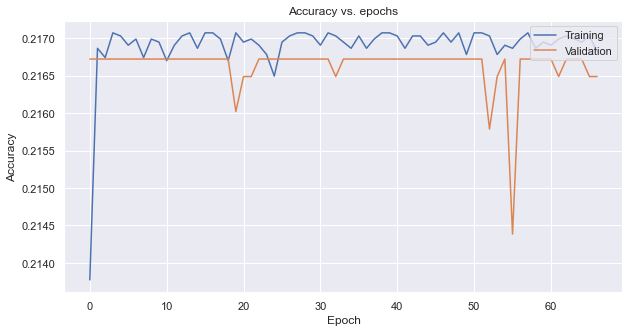

In [229]:
#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['accuracy'],label='accuracy')
plt.plot(historydf['val_accuracy'],label='val_accuracy')
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

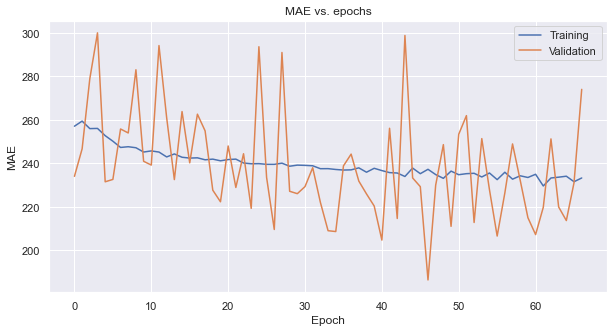

In [230]:
#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['mae'],label='mae')
plt.plot(historydf['val_mae'],label='val_mae')
plt.title('MAE vs. epochs')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [235]:
print(f"Average Fire Size: {df.fire_size.mean()}")
print(f"Standard Deviation of Fire Size: {df.fire_size.std()}")


Average Fire Size: 165.51327134657964
Standard Deviation of Fire Size: 728.6857104261223
